In [1]:
import numpy as np
import numpyro
import jax
import asterion as ast
from jax import random
from numpyro import handlers
from asterion.models import GlitchModel

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
key = random.PRNGKey(11)

n = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
truths = {
    '_nu_max': 2300.0,
    'delta_nu': 110.0,
    'epsilon': 1.3,
    'log_a_he': -2.1,
    'log_b_he': -6.1,
    'log_tau_he': -3.06,
    'phi_he': 1.0,
    'log_a_cz': 5.5,
    'log_tau_cz': -2.6,
    'phi_cz': -0.9,
}

key, k1, k2 = random.split(key, 3)

nu_max_err = 25.
nu_max = np.array(truths['_nu_max'] + nu_max_err * random.normal(k1))

delta_nu_err = 0.1
delta_nu = np.array(truths['delta_nu'] + delta_nu_err * random.normal(k2))

INFO[2022-02-28 11:06:13,945]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-02-28 11:06:13,946]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-02-28 11:06:13,947]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [3]:
model = GlitchModel(n, (nu_max, nu_max_err), (delta_nu, delta_nu_err))

In [4]:
true_model = handlers.condition(model, data=truths)

In [5]:
true_model = handlers.substitute(true_model, {
    'kernel_length': 5.0,
    'kernel_var': 0.1*delta_nu,
})

In [6]:
num_samples = 50
key, k = random.split(key)

predictive = numpyro.infer.Predictive(true_model, num_samples=num_samples)
true_pred = predictive(k, pred=True)

Plot samples from the "true posterior". This shows the GP at work, showing the prior on background functions. We can randomly highlight one and take that as the "truth" for this example.

In [7]:
import matplotlib.pyplot as plt

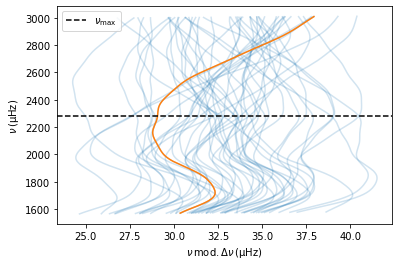

In [27]:
key, k = random.split(key)
i = random.randint(k, (), 0, num_samples)

nu_mod = (true_pred['nu_pred'] - model.n_pred*delta_nu) % delta_nu

fig, ax = plt.subplots()

ax.plot(nu_mod.T, true_pred['nu_pred'].T, color='C0', alpha=0.2)
ax.plot(nu_mod[i], true_pred['nu_pred'][i], color='C1')

ax.axhline(nu_max, linestyle='--', color='k', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [28]:
# Let's add some more to the truths
truths['nu'] = true_pred['nu_obs'][i]
truths['he_amplitude'] = true_pred['he_amplitude'][i]

In [29]:
key, k = random.split(key)
nu_err = 0.01
nu = truths['nu'] + nu_err * random.normal(k)

In [30]:
import matplotlib.pyplot as plt

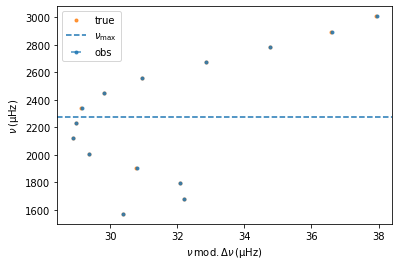

In [31]:
nu_mod = truths['nu'] % delta_nu
nu_mod_obs = nu % delta_nu

fig, ax = plt.subplots()

ax.errorbar(nu_mod_obs, nu, xerr=nu_err, fmt='.', label='obs', alpha=0.8)
ax.plot(nu_mod, truths['nu'], '.', label='true', alpha=0.8)

ax.axhline(nu_max, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [32]:
from asterion.inference import Inference

In [33]:
infer = Inference(model, nu=truths['nu'], seed=40)

In [34]:
infer.prior_predictive()

In [35]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

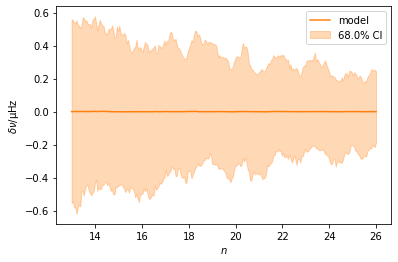

In [36]:
ast.plot_glitch(data, group='prior');

In [37]:
infer.sample(depth=8)

Running nested sampling using the 'multi_ellipsoid' sampler with 100 live points and 100000 maximum samples...
Completed in 17.3 seconds.


In [38]:
infer.posterior_predictive()

In [39]:
data = infer.get_data()
data

/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

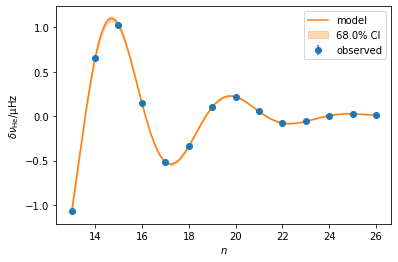

In [40]:
ast.plot_glitch(data, kind='He');

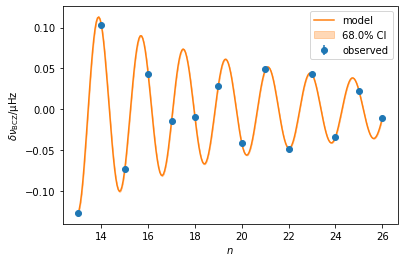

In [41]:
ast.plot_glitch(data, kind='CZ');

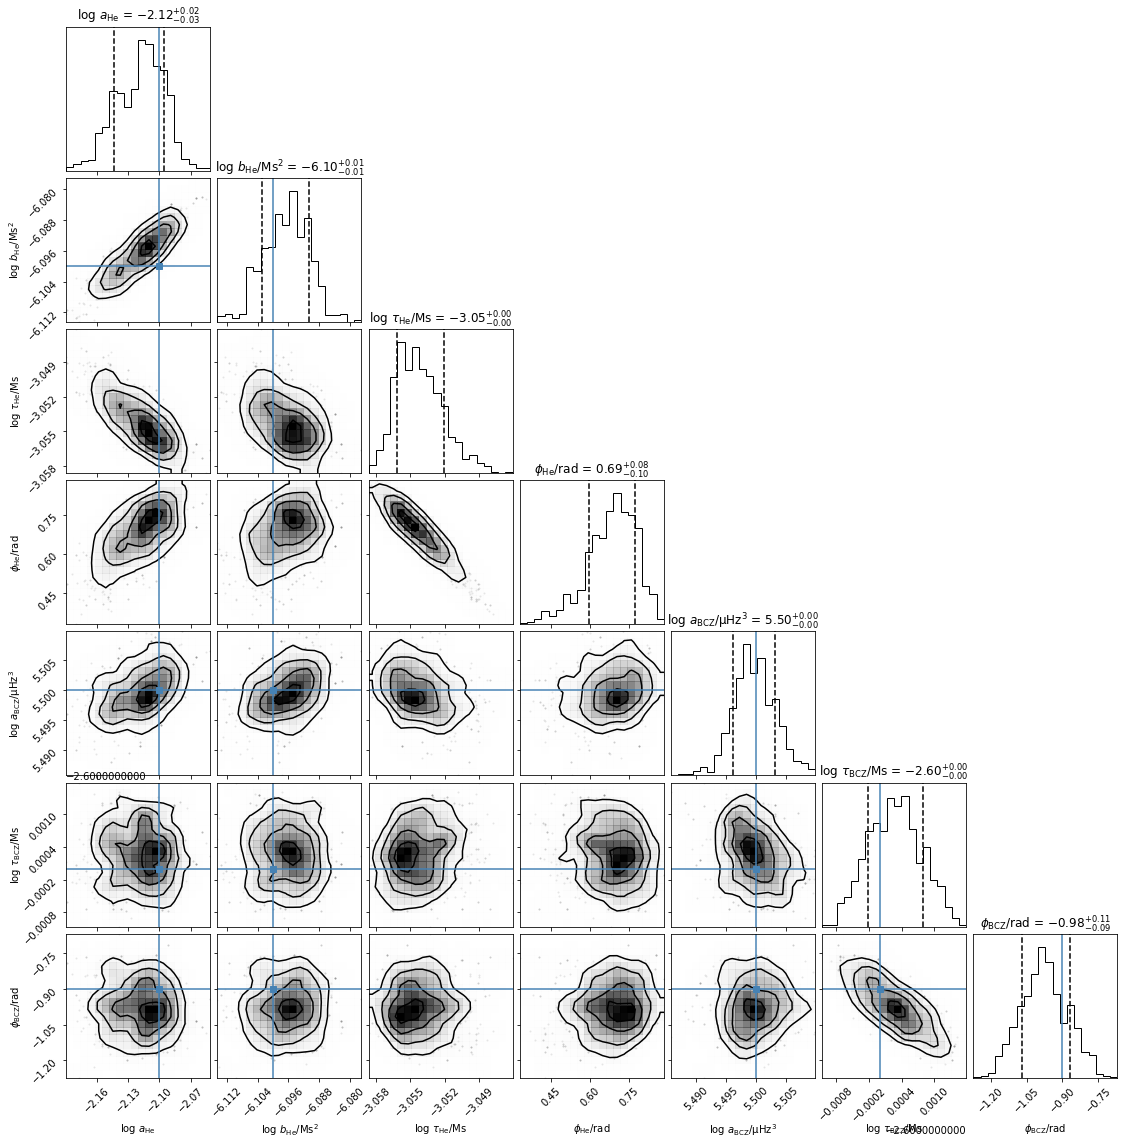

In [42]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names, truths=truths);

In [46]:
truths['log_tau_he']

-3.06

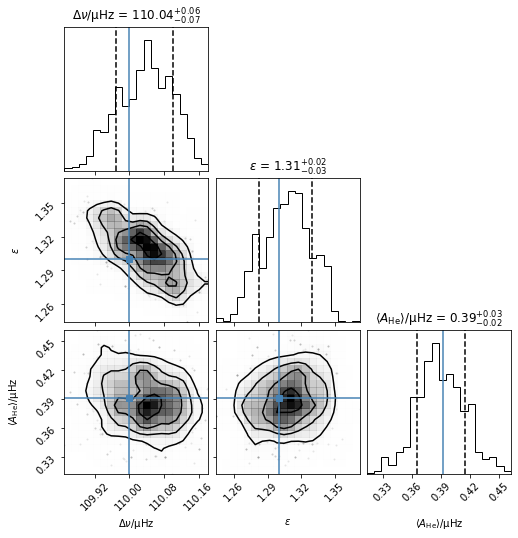

In [47]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'he_amplitude'], truths=truths);

In [49]:
from netCDF4 import Dataset

In [67]:
root = Dataset('../tests/test_data.nc', 'w')

In [68]:
t = root.createGroup('truths')
root.createDimension("n", len(n))
for key, value in truths.items():
    print(value)
    if np.array(value).shape == (): 
        v = t.createVariable(key, "f8")
    else:
        v = t.createVariable(key, "f8", ("n",))
    v[:] = value

2300.0
110.0
1.3
-2.1
-6.1
-3.06
1.0
5.5
-2.6
-0.9
[1570.36124895 1682.19831391 1792.07611987 1900.7703377  2009.35950261
 2118.87468118 2228.96684487 2339.13149066 2449.8103176  2560.94287277
 2672.83575802 2784.74552359 2896.58972222 3007.93374648]
0.39194594414805123


In [69]:
o = root.createGroup('observed')

_nu = o.createVariable("nu", "f8", ("n",))
_nu_err = o.createVariable("nu_err", "f8")

_nu[:] = nu
_nu_err[:] = nu_err

In [71]:
p = root.createGroup('model')

_n = p.createVariable("n", "f8", ("n",))
_n[:] = n

p.createDimension("dist", 2)

_nu_max = p.createVariable("nu_max", "f8", ("dist",))
_delta_nu = p.createVariable("delta_nu", "f8", ("dist",))

_nu_max[:] = [nu_max, nu_max_err]
_delta_nu[:] = [delta_nu, delta_nu_err]

In [90]:
root.close()